In [1]:
using PyPlot, PyCall
using LinearAlgebra

In [2]:
"""
    plot_mapped_grid(R, n1, n2=n1)

Create a Cartesian grid of dimensions (n1+1)-by-(n2+1) on the unit square.
Map it by the functions xy = R(ξη). Plot the resulting structured grid.

Example:

    identity_map(ξη) = ξη
    plot_mapped_grid(identity_map, 40);
"""
function plot_mapped_grid(R, n1, n2=n1)
    xy = Vector{Float64}[ R([ξ,η]) for ξ in (0:n1)./n1, η in (0:n2)./n2 ]
    x,y = first.(xy), last.(xy)
    plot(x, y, "k", x', y', "k", linewidth=1)
    axis("equal")
end

"""
    tplot(p, t, u=nothing)

If `u` == nothing: Plot triangular mesh with nodes `p` and triangles `t`.
If `u` == solution vector: Plot filled contour color plot of solution `u`.
"""
function tplot(p, t; u=nothing, pts=false)
    axis("equal");
    if u == nothing
        tripcolor(p[:,1], p[:,2], Array(t .- 1), 0*t[:,1],
                  cmap="Set3", edgecolors="k", linewidth=1);
    else
        tricontourf(p[:,1], p[:,2], Array(t .- 1), u[:], 20);
    end
    if pts
        plot(p[:,1], p[:,2], ".", markersize=18);
    end
    draw();
end

tplot

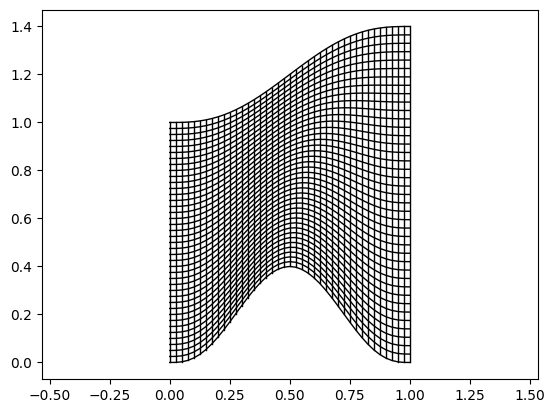

In [17]:
    
function tfi_linear(ξη)
    A = 0.4
    
    xbot = 0  # left boundary
    xtop = 1  # right boundary
    ybot(x) = 64A * x^3 * (1 - x)^3  # bottom boundary
    ytop(x) = 1 + A * x^3 * (6x^2 - 15x + 10)  # top boundary
    
    # known corners
    R00 = [xbot, ybot(xbot)]
    R01 = [xbot, ytop(xbot)]
    R10 = [xtop, ybot(xtop)]
    R11 = [xtop, ytop(xtop)]

    # interpolated boundaries
    R0η(η) = [xbot, η * ytop(xbot)]
    R1η(η) = [xtop, η * ytop(xtop)]
    Rξ0(ξ) = [ξ, ybot(ξ)]
    Rξ1(ξ) = [ξ, ytop(ξ)]

    ξ, η = ξη

    b = (1 - ξ)*R0η(η) + ξ*R1η(η) + (1 - η)*Rξ0(ξ) + η*Rξ1(ξ)
    c = (1 - ξ)*(1 - η)*R00 + (1 - ξ)*η*R01 + ξ*(1 - η)*R10 + ξ*η*R11

    return b - c
end
plot_mapped_grid(tfi_linear, 40);
savefig("figs/linear.pdf")

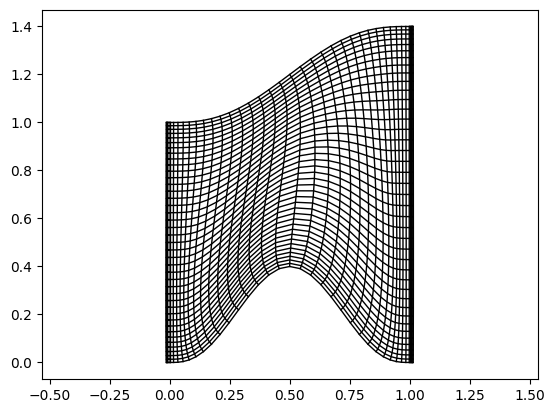

[0.4994000000000054, 0.00023980580080171254]


In [34]:
function tfi_orthogonal(ξη)
    A = 0.4
    T = 0.5

    ybot(x) = 64A * x^3 * (1 - x)^3  # bottom boundary
    ytop(x) = 1 + A * x^3 * (6x^2 - 15x + 10)  # top boundary

    H0(x) = 2x^3 - 3x^2 + 1
    H1(x) = 3x^2 - 2x^3
    dH0(x) = x^3 - 2x^2 + x
    dH1(x) = x^3 - x^2

    n_top(x) = [-3A*x^2*(6x^2 - 15x + 10) - A*x^3*(12x - 15), 1]
    n_bot(x) = [64 * 3A * x^2 * (1 - x)^2 * (2x - 1), 1]
    nhat_top(x) = n_top(x) / norm(n_top(x))
    nhat_bot(x) = n_bot(x) / norm(n_bot(x))

    ξ_to_(x) = H0(x) + T * dH0(x) + T * dH1(x)
    
    Rξ0(x) = [ξ_to_(x), ybot(ξ_to_(x))]
    Rξ1(x) = [ξ_to_(x), ytop(ξ_to_(x))]
    dRξ0(x) = T * nhat_bot(ξ_to_(x))
    dRξ1(x) = T * nhat_top(ξ_to_(x))

    ξ, η = ξη

    R = [Rξ0(ξ) Rξ1(ξ) dRξ0(ξ) dRξ1(ξ)]
    H = [H0(η), H1(η), dH0(η), dH1(η)]
    
    return R * H
end
plot_mapped_grid(tfi_orthogonal, 40);
savefig("figs/orthogonal.pdf")

f = tfi_orthogonal
h = 1/100
x = 0
y = 0
dR = (-3/2*f([x, y]) + 2*f([x+h,y]) - 1/2*f([x+2h, y])) / h
println(dR)

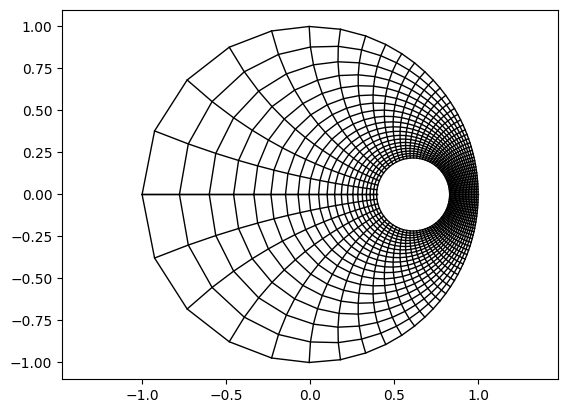

In [104]:
function conformal_mapping(ξη)
    ξ, η = ξη
    z = ξ + 2pi * η * 1im
    w = (2*exp(z) - 3) / (3 * exp(z) - 2)
    return [real(w), imag(w)]
end

plot_mapped_grid(conformal_mapping, 20, 80);
savefig("figs/conformal.pdf")

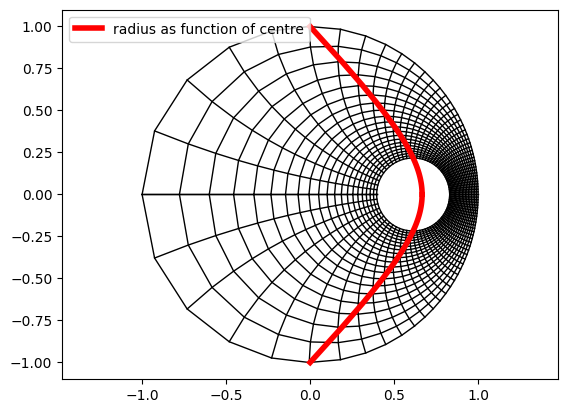

0.6133346174755341
0.21745731028610907


In [117]:
plot_mapped_grid(conformal_mapping, 20, 80);
r(x) = 5exp(x) / (9exp(2x) - 4)
c(x) = (6(exp(2x) - 1)) / (9exp(2x) - 4)
x = collect(0:0.1:2pi)
plot(c.(x), r.(x), "r", linewidth=4, label="radius as function of centre")
plot(c.(x), -r.(x), "r", linewidth=4)
legend()
savefig("figs/conformal_cr.pdf")
println(c(1))
println(r(1))

In [7]:
"""
    p = add_edge_points(pv, hmax)

    Adds points along the edge of the polygon with verticies pv,
    such that distance between the points are less than hmax
"""
function add_edge_points(pv, hmax)
    for j = 2:size(pv)[1]  # assume pv is ordered
        direction = pv[j, :] - pv[j-1, :]
        dist = norm(direction)
        n = dist ÷ hmax
        h = 1 / (n + 1)
        for i = 1:n
            new = @. pv[j-1, :] + direction * i * h
            pv = [pv; new']
        end
    end
    return pv[2:end, :]  # first polygon is closed, so remove dupliated point
end


add_edge_points

In [8]:
"""
    T = out_triangles(p, T, e)

    returns the list of triangles without the ones outside the polygon
    Calculates a single point in each triangle, and uses inpolygon to check if theyre outside
    p: points in mesh
    T: indicies in p forming each triangle
    e: points on edge of polygon
"""
function out_triangles(p, T, e)
    test_points = zeros(size(T)[1], 2)
    for t = 1:size(T)[1]
        a, b, c = T[t, :]
        test_points[t, :] = p[a, :] + 0.5(p[b, :] - p[a, :]) + 0.25(p[c, :] - p[b, :])
    end
    # e is a closed polygon, so check for all but first point on edge
    inside = inpolygon(test_points, e[2:end, :])
    return T[inside, :]
end

out_triangles

In [9]:
function out_delaunay(p, e)
    t = delaunay(p)
    out_triangles(p, t, e)
end

out_delaunay (generic function with 1 method)

In [10]:
function largest_area(p, T, hmax)
    worst = hmax^2
    idx = false
    kick = []
    for m = 1:size(T)[1]
        x1, y1 = p[T[m, 1], :]
        x2, y2 = p[T[m, 2], :]
        x3, y3 = p[T[m, 3], :]
        A = x1*y2 + x2*y3 + x3*y1 - y1*x2 - y2*x3 - y3*x1
        if A > worst
            worst = A
            idx = m
        elseif A < 1e-12
            T = T[1:end .!= m, :]
        end
    end
    return idx, T
end

largest_area (generic function with 1 method)

In [11]:
function circumcentre(ax, bx, cx, ay, by, cy)
    D = 2(ax*(by - cy) + bx*(cy - ay) + cx*(ay - by))

    A = ax^2 + ay^2
    B = bx^2 + by^2
    C = cx^2 + cy^2

    Ux = (A*(by - cy) + B*(cy - ay) + C*(ay - by)) / D
    Uy = (A*(bx - cx) + B*(cx - ax) + C*(ax - bx)) / D

    return [Ux -Uy]  # defined Uy negatively
end

circumcentre (generic function with 1 method)

In [12]:
function refine(p, t)
    edges, _, _ = all_edges(t)
    for e = 1:size(edges)[1]
        p1 = p[edges[e, 1], :]
        p2 = p[edges[e, 2], :]
        new = p1 + 0.5(p2 - p1)
        p = [p; new']
    end
    return p
end

refine (generic function with 1 method)

In [13]:
"""
    p, t, e = pmesh(pv, hmax, nref)
"""
function pmesh(pv, hmax, nref)
    p = add_edge_points(pv, hmax)
    too_large = true
    while too_large
        t = out_delaunay(p, pv)
        idx, t = largest_area(p, t, hmax)
        
        if idx != false
            p = [p; circumcentre(p[t[idx, :], :]...)]
        else
            too_large = false
        end
    end
    
    t = out_delaunay(p, pv)
    for i in 1:nref
        p = refine(p, t)
        t = out_delaunay(p, pv)
    end

    e = boundary_nodes(t)
    return p, t, e
end

pmesh

In [14]:
"""
    t = delaunay(p)

Delaunay triangulation `t` of N x 2 node array `p`.
"""
function delaunay(p)
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](p[:,1], p[:,2])
    return Int64.(t[:triangles] .+ 1)
end

"""
    inside = inpolygon(p, pv)

Determine if each point in the N x 2 node array `p` is inside the polygon
described by the NE x 2 node array `pv`.
"""
function inpolygon(p, pv)
    path = pyimport("matplotlib.path")
    poly = path[:Path](pv)
    inside = [poly[:contains_point](p[ip,:]) for ip = 1:size(p,1)]
end

"""
    edges, boundary_indices, emap = all_edges(t)

Find all unique edges in the triangulation `t` (ne x 2 array)
Second output is indices to the boundary edges.
Third output emap (nt x 3 array) is a mapping from local triangle edges
to the global edge list, i.e., emap[it,k] is the global edge number
for local edge k (1,2,3) in triangle it.
"""
function all_edges(t)
    etag = vcat(t[:,[1,2]], t[:,[2,3]], t[:,[3,1]])
    etag = hcat(sort(etag, dims=2), 1:3*size(t,1))
    etag = sortslices(etag, dims=1)
    dup = all(etag[2:end,1:2] - etag[1:end-1,1:2] .== 0, dims=2)[:]
    keep = .![false;dup]
    edges = etag[keep,1:2]
    emap = cumsum(keep)
    invpermute!(emap, etag[:,3])
    emap = reshape(emap,:,3)
    dup = [dup;false]
    dup = dup[keep]
    bndix = findall(.!dup)
    return edges, bndix, emap
end

"""
    e = boundary_nodes(t)

Find all boundary nodes in the triangulation `t`.
"""
function boundary_nodes(t)
    edges, boundary_indices, _ = all_edges(t)
    return unique(edges[boundary_indices,:][:])
end

boundary_nodes

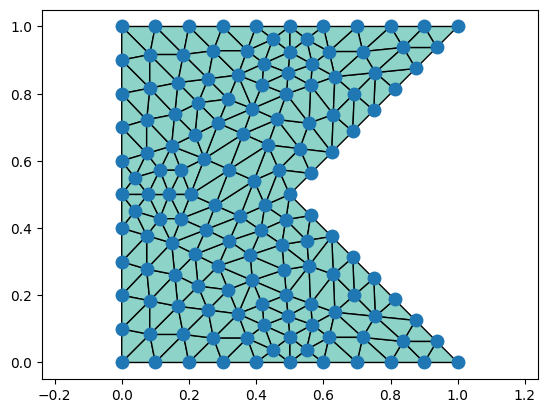

In [22]:
pv = [0 0; 1 0; .5 .5; 1 1; 0 1; 0 0]
p, t, e = pmesh(pv, 0.2, 1)
tplot(p, t, pts=true)
savefig("figs/triangulated.pdf")
